# MAE6292 - Homework \# 3

Calibration with DLT and 3D scene construction

## Import Modules



In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import cv2

## Jupyter Notebook / VSCode

It turns out that `cv2.imshow()` does not work in Jupter Notebook as well. You may use the follwing function `cv2_imshow` instead. 

Also, we are importing tools developed in class as `mae6292` module.

In [3]:
#from mae6292.imshow import cv2_imshow
#import mae6292.tools as mae6292

In [4]:
# %load tools.py
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class WireFrameCamera:
    def __init__(self, width=1, height=0.8, f=0.5):
        self.width = width
        self.height = height
        self.f = f

        self.vertices=np.empty((3,5))
        self.vertices[:,0]=[0, 0, 0]
        self.vertices[:,1]=[-width/2, height/2, f]
        self.vertices[:,2]=[width/2, height/2, f]
        self.vertices[:,3]=[width/2, -height/2, f]
        self.vertices[:,4]=[-width/2, -height/2, f]

        self.edges=[(0,1), (0,2), (0,3), (0,4), (1,2), (2,3), (3,4), (4,1)]

    def draw(self, R, T):
        vertices_W = np.empty((3,5))
        vertices_W = R.T@(self.vertices - T@np.ones((1,5)))

        fig = plt.figure(dpi=150)
        # ax = fig.gca(projection='3d') depreciated 
        ax = fig.add_subplot(projection='3d')

        for edge in self.edges:
            plt.plot(vertices_W[0,list(edge)],vertices_W[1,list(edge)],vertices_W[2,list(edge)],'b',linewidth=0.5)

        return fig, ax

class ChessBoard:
    faces=[(0,1,2,3)]
    square_vertices = np.zeros((3, 4))
    square_vertices[:,0] = [0,0,0]
    square_vertices[:,1] = [1,0,0]
    square_vertices[:,2] = [1,1,0]
    square_vertices[:,3] = [0,1,0]

    def __init__(self, CHECKER=(8,6), origin=(0.0)):
        self.origin = origin
        self.CHECKER = CHECKER

    def draw(self, ax):
        for i in range(self.CHECKER[0]+1):
            for j in range(self.CHECKER[1]+1):
                square_vertices_shifted = self.square_vertices + np.array([[i+self.origin[0],j+self.origin[1],0]]).T*np.ones((1,4))

                patch = [[tuple(square_vertices_shifted[:,self.faces[0][i]]) for i in range(len(self.faces[0]))]]
                patch_collection = Poly3DCollection(patch, alpha =0.5)
                if (i+j) % 2 == 1:
                    patch_collection.set_color('w')
                else:
                    patch_collection.set_color('k')

                    ax.add_collection3d(patch_collection)

def calibrateCamera_Tsai(p, P):
    # p : homogeneous coordinates of pixel in the image frame
    # P : homogeneous coordinates of points in the world frame
    assert p.shape[0] == 3, "p : homogeneous coordinates of pixel in the image frame of 3 by n"
    assert P.shape[0] == 4, "P : homogeneous coordinates of points in the world frame"
    assert p.shape[1] == P.shape[1], "number of columns of p shold match with P"

    n = p.shape[1]
    p_uv = p[0:2,:]/p[2,:]

    Q = np.empty((0, 12))
    for i in range(n):
        Qi_0 = np.array([ [1,0, -p_uv[0,i]], [0, 1, -p_uv[1,i]]] )
        Qi = np.kron(Qi_0, P[:,i].T)
        Q = np.append(Q, Qi, axis=0)

    # 1. Find M_tilde using SVD

    U, S, VT = linalg.svd(Q)
    M_tilde = VT.T[:,-1].reshape(3,4)
    # print(M_tilde /M_cv) # M is determined up to scale

    # 2. RQ factorization to find K_tilde and R

    K_tilde, R = linalg.rq(M_tilde [:,0:3])

    # 3. Resolve the ambiguity of RQ factorization
    D = np.diag( np.sign(np.diag(K_tilde)) )
    K_tilde  = K_tilde@D
    R = D@R

    # 4. Find T
    T = linalg.solve(K_tilde, M_tilde[:,-1]).reshape(3,1)

    # 5. Recover scale

    s = 1/K_tilde[2,2]
    K = s*K_tilde
    M = s*M_tilde

    # 6. Resolve sign ambiguity
    if linalg.det(R) < 0:
        R = -R
        T = -T
        M = -M


    return K, R, T, M


In [5]:
# %load imshow.py
import matplotlib.pyplot as plt
import numpy as np
import cv2

def cv2_imshow(image):
    # developed by Kanishke Gamagedara, udpated by MAE6292
    plt.figure(dpi=200)
    mode = len(np.shape(image))
    if mode==3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    elif mode==2:
        plt.imshow(image, cmap='gray')
    else:
        print('Unsuported image size')
    plt.xticks([]), plt.yticks([])
    plt.axis('off')



## Getting Data From HW#2

In HW#2, we made a virtual cube on the photo image as follows.

![](./img_cube.png)

First, we have to load several variables from HW#2. 

1. Append your HW2 with the following code to create a data file, `HW2.npz` that containts the listed variables. 

`np.savez('HW2.npz', P = vertices, p = M@vertices, K_cv = K, R_cv = R, T_cv = T, M_cv=M)`

2. Copy the data file `HW2.npz` to the current folder of HW3.

3. Excute the following code to load variables from the data file. 

In [6]:
np.set_printoptions(precision=5)

with np.load('HW2.npz') as data:
    P = data['P']
    P = P.T
    p = data['p']
    K_cv = data['K_cv']
    R_cv = data['R_cv']
    T_cv = data['T_cv']
    M_cv = data['M_cv']

#print(P.T)
print('K_cv = ',K_cv)
print('R_cv = ',R_cv)
print('T_cv = ',T_cv)
print('M_cv = ',M_cv)

K_cv =  [[1.04100e+03 0.00000e+00 5.08037e+02]
 [0.00000e+00 9.78425e+02 3.06480e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
R_cv =  [[ 0.96978 -0.10385  0.22079]
 [-0.08634  0.70029  0.70862]
 [-0.22821 -0.70626  0.67016]]
T_cv =  [[-2.11136]
 [-1.65812]
 [11.05752]]
M_cv =  [[ 8.93594e+02 -4.66920e+02  5.70311e+02  3.41971e+03]
 [-1.54420e+02  4.68726e+02  8.98719e+02  1.76656e+03]
 [-2.28213e-01 -7.06263e-01  6.70158e-01  1.10575e+01]]


## Problem 1 (DLT)

In this part, 

1. Using `K, R, T, M = mae6292.calibrateCamera_Tsai(p, P)` calibrate the camera according to Tsai's method.

2. Print `K, R, T, M` and make it sure that they are consistent with the above values computed by OpenCV.

3. Using [scipy.linalg.norm()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.norm.html), compute $\|K-K_{cv}\|$, $\|R-R_{cv}\|$, $\|T-T_{cv}\|$, and $\|M-M_{cv}\|$, and print.


In [7]:
# 1. compute K, R, T, M
K,R,T,M = calibrateCamera_Tsai(p, P) #used P.T to ensure that it has 4 rows !!!! it should not affect p because I already made the change when I created HW@.npz for p=M@vertices.T

# 2. print K, R, T, M
print('K =', K)
print('\nR =', R)
print('\nT =', T)
print('\nM =', M)
print('\n')

# 3. compute and print errors
from scipy.linalg import norm
K_err = norm(K-K_cv) 
R_err = norm(R-R_cv)
T_err = norm(T-T_cv)
M_err = norm(M-M_cv)

print('|K - K_cv|=', K_err)
print('|R - R_cv|=', R_err)
print('|T - T_cv|=', T_err)
print('|M - M_cv|=', M_err)

K = [[ 1.04100e+03 -5.44370e-11  5.08037e+02]
 [ 0.00000e+00  9.78425e+02  3.06480e+02]
 [ 0.00000e+00  0.00000e+00  1.00000e+00]]

R = [[ 0.96978 -0.10385  0.22079]
 [-0.08634  0.70029  0.70862]
 [-0.22821 -0.70626  0.67016]]

T = [[-2.11136]
 [-1.65812]
 [11.05752]]

M = [[ 8.93594e+02 -4.66920e+02  5.70311e+02  3.41971e+03]
 [-1.54420e+02  4.68726e+02  8.98719e+02  1.76656e+03]
 [-2.28213e-01 -7.06263e-01  6.70158e-01  1.10575e+01]]


|K - K_cv|= 7.652090198574414e-10
|R - R_cv|= 6.064467649740775e-13
|T - T_cv|= 6.28812797256199e-12
|M - M_cv|= 1.113643255479052e-09


## Problem 2 (3D Scene Construction)

1. The following codes generate a wireframe camera at the pose `(R,T)` defined above. You may need to adjust the axis limits at the following lines. 

```
ax.axes.set_xlim3d(left=-2, right=10)
ax.axes.set_ylim3d(bottom=-2, top=6) 
ax.axes.set_zlim3d(bottom=0, top=-6)
```

2. Using the following command generate the checker board 

```
cb = mae6292.ChessBoard( (CHECKER_ROW, CHECKER_COL), (x of upper-left corner, y of upper left corner) )``
cb.draw(ax)
```

See the example in [https://github.com/GW-MAE6292/python_examples/tree/main/DLT](https://github.com/GW-MAE6292/python_examples/tree/main/DLT)

3. In the above, the homogeneous coordinates of the vertices of the cube in the world frame are stored in the 4 by 8 np.array `P`. Convert it into the 3 by 8 np.array `P_W` of the world coordinates.


4. Read [3D line plot in python](https://medium.com/@rohitadnaik/3d-line-plot-in-python-2fbeca99b9ba). 

For example, the following command generate a line from $(0,0,0)$ to $(0,0,-1)$.

```
ax.plot([0, 0], [0, 0], [0, -1],'r',linewidth=1)
```
Draw a 3D wire-frame cube using `P_W` and the above command.

5. Save the image as `prob2.png` using

```
plt.savefig('prob2.png')
```

The end results should be similar as

![](./prob2_example.png)

[[ 2.  3.  3.  2.  2.  3.  3.  2.]
 [ 1.  1.  2.  2.  1.  1.  2.  2.]
 [ 0.  0.  0.  0. -1. -1. -1. -1.]]

 [2. 3. 3. 2.]

 [1. 1. 2. 2. 1. 1. 2. 2.]

 [ 0.  0.  0.  0. -1. -1. -1. -1.]


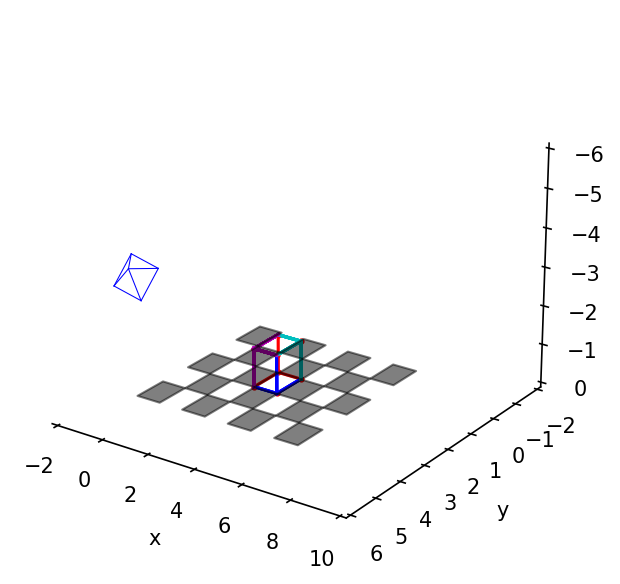

In [8]:
# uncomment the following line for interactive view of the image
#%matplotlib notebook
from mpl_toolkits import mplot3d
# 1. draw wire-frame camera
camera = WireFrameCamera()
fig, ax = camera.draw(R,T)
ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

#  change the axis limit if needed
ax.axes.set_xlim3d(left=-2, right=10)
ax.axes.set_ylim3d(bottom=6, top=-2) 
ax.axes.set_zlim3d(bottom=0, top=-6) 

ax.elev = 23  # Elevation angle (angle above the x-y plane)
ax.azim = 305  # Azimuth angle (angle around the z-axis)

# 2. draw chess board
cb = ChessBoard( (6, 4), (-1,-1) )
cb.draw(ax)

# 3. convert the homogeneous coordinates P into a 3X8 np.array and this draws the points
P_W = P[0:3,:]/P[3,:]
ax.plot(P_W[0,:],P_W[1,:],P_W[2,:],'o',markersize=2,c='r')

# 4. draw wire cube
#ax.plot([0, 0], [0, 0], [0, -1],'r',linewidth=1)
#ax.plot(P_W[0,4:],P_W[1,4:],P_W[2,4:],'r',linewidth=1)
#ax.plot(P_W[0,:4],P_W[1,:4],P_W[2,:4],'r',linewidth=1)
#ax.plot([2,2],[1,1],[0,-1],'r',linewidth=1)


vertex0 = [1,3,4]
vertex2 = [1,3,6]
vertex5 = [1,4,6]
vertex7 = [3,4,6]

for i in vertex0:
    ax.plot([P_W[0,0],P_W[0,i]],[P_W[1,0],P_W[1,i]],[P_W[2,0],P_W[2,i]],'r')
    for j in vertex2:
        ax.plot([P_W[0,2],P_W[0,j]],[P_W[1,2],P_W[1,j]],[P_W[2,2],P_W[2,j]],'b')
        for k in vertex5:
            ax.plot([P_W[0,5],P_W[0,k]],[P_W[1,5],P_W[1,k]],[P_W[2,5],P_W[2,k]],'c')
            for z in vertex7:
                ax.plot([P_W[0,7],P_W[0,z]],[P_W[1,7],P_W[1,z]],[P_W[2,7],P_W[2,z]],'m')

# 5. save 
plt.savefig('prob2.png')
print(P[0:3,:]/P[3,:])
print('\n',P_W[0,4:])
print('\n',P_W[1,:])
print('\n',P_W[2,:])

## How to Turn in

Make it sure you add the following files to the repository before pusing it back to github.
1. prob2.png
